## **Part 2: Stitch five images together to create a panorama**

In [2]:
filenames = ["images/1.png", "images/2.png", "images/3.png", "images/4.png", "images/5.png"]

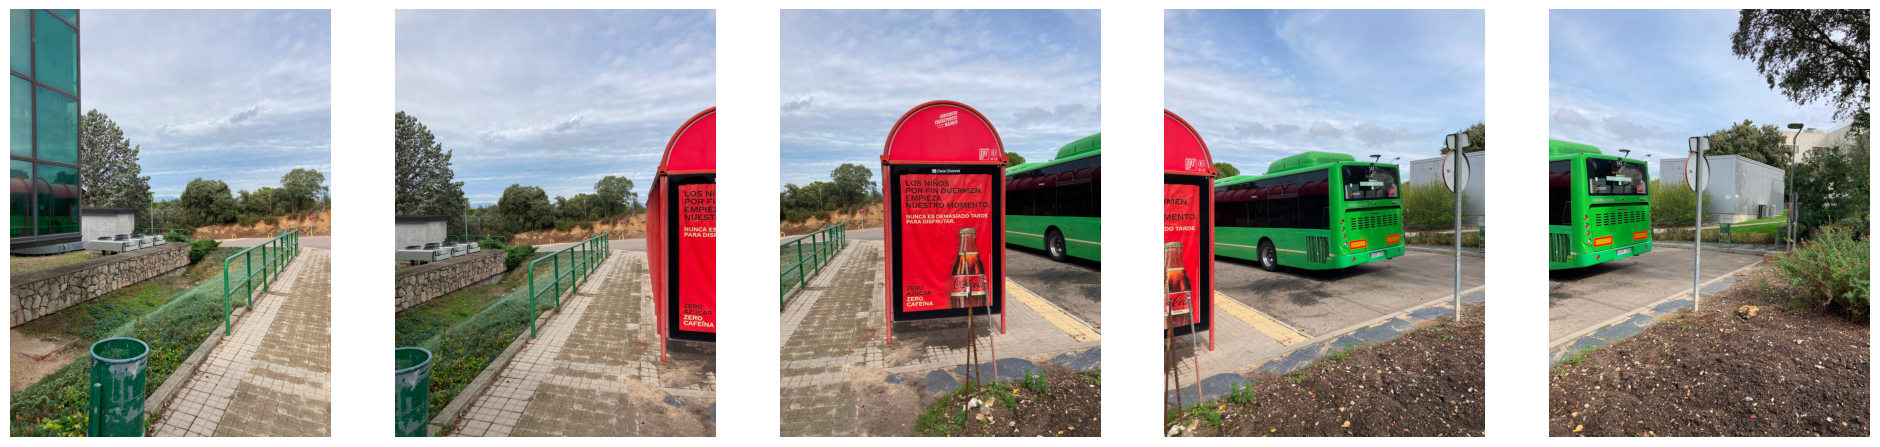

In [16]:
### TODO
# Draw images
import cv2
import matplotlib.pyplot as plt
import copy

def draw_images(images):
    width = len(images)
    fig, axes = plt.subplots(1, width, figsize=(24, 6))
    
    if width == 1:
        axes = [axes]
        
    for i in range(width):
        axes[i].imshow(images[i])
        axes[i].axis("off")

imgs = []

for i in filenames:
    img = cv2.imread(i)
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img_color)

draw_images(imgs)


#### The goal of this part of the assignment is to combine five horizontally overlapping photographs into a single panoramic image. Images must be supplied in left-to-right order.

1. Detectamos punto de interés mediante con técnicas de extracción de esquinas

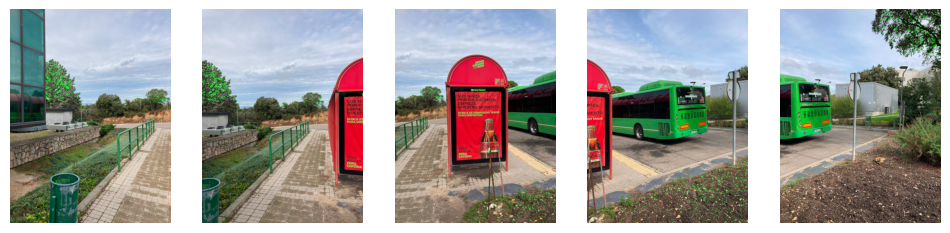

In [6]:
keypoints_harris = []

harris_detector = cv2.GFTTDetector_create()
orb = cv2.ORB_create()


for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp_harris = harris_detector.detect(gray, None)
    keypoints_harris.append(kp_harris)

_imgs = copy.deepcopy(imgs)
for idx in range(len(_imgs)):
    cv2.drawKeypoints(_imgs[idx], keypoints_harris[idx], _imgs[idx], (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

draw_images(_imgs)

descriptors_harris = []

for img, kp in zip(imgs, keypoints_harris):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = orb.compute(gray, kp)
    descriptors_harris.append(des)


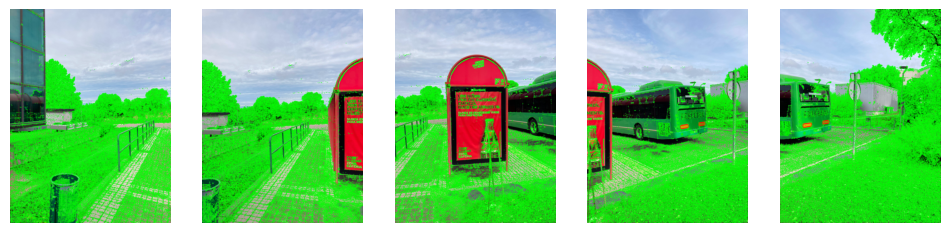

In [7]:
keypoints_fast = []

fast_detector = cv2.FastFeatureDetector_create()
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp_fast = fast_detector.detect(gray, None)
    keypoints_fast.append(kp_fast)


_imgs = copy.deepcopy(imgs)
for idx in range(len(_imgs)):
    cv2.drawKeypoints(_imgs[idx], keypoints_fast[idx], _imgs[idx], (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

draw_images(_imgs)

descriptors_fast = []

for img, kp in zip(imgs, keypoints_fast):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = orb.compute(gray, kp)
    descriptors_fast.append(des)

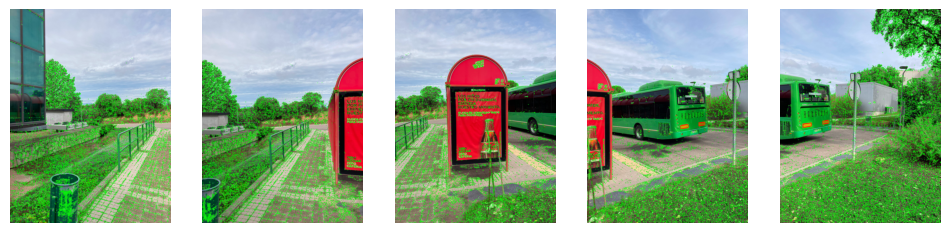

In [8]:
keypoints_sift = []

sift_detector = cv2.SIFT_create()
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp_sift = sift_detector.detect(gray, None)
    keypoints_sift.append(kp_sift)

_imgs = copy.deepcopy(imgs)

for idx in range(len(_imgs)):
    cv2.drawKeypoints(_imgs[idx], keypoints_sift[idx], _imgs[idx], (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

draw_images(_imgs)

descriptors_sift = []

for img, kp in zip(imgs, keypoints_sift):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = sift_detector.compute(gray, kp)
    descriptors_sift.append(des)


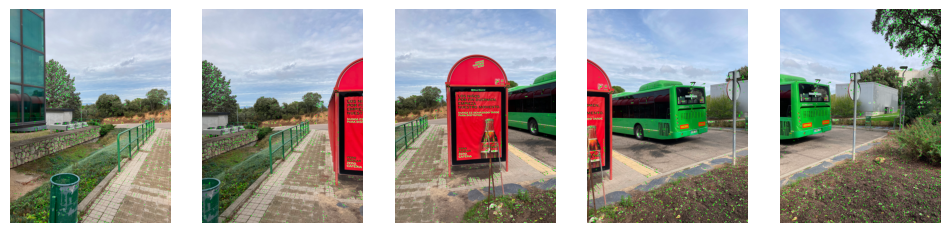

In [9]:
keypoints_mser = []

mser_detector = cv2.MSER_create()
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp_mser = mser_detector.detect(gray, None)
    keypoints_mser.append(kp_mser)

_imgs = copy.deepcopy(imgs)

for idx in range(len(_imgs)):
    cv2.drawKeypoints(_imgs[idx], keypoints_mser[idx], _imgs[idx], (0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

draw_images(_imgs)

descriptors_mser = []

for img, kp in zip(imgs, keypoints_mser):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = sift_detector.compute(gray, kp)
    descriptors_mser.append(des)

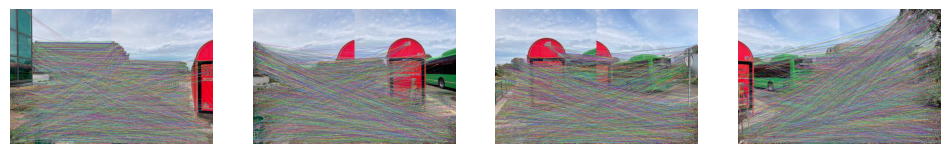

In [10]:
### TODO
# Draw all matches

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches_sift = []
pairs_sift = []

for i in range(len(imgs) - 1):
    m = bf.match(descriptors_sift[i], descriptors_sift[i+1])
    m = sorted(m, key=lambda x: x.distance)
    matches_sift.append(m)
    pairs_sift.append((i, i+1))

_imgs = []
for idx, (elem1, elem2) in enumerate(pairs_sift):
    _imgs.append(cv2.drawMatches(imgs[elem1], keypoints_sift[elem1], imgs[elem2], keypoints_sift[elem2], matches_sift[idx], None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))
draw_images(_imgs)

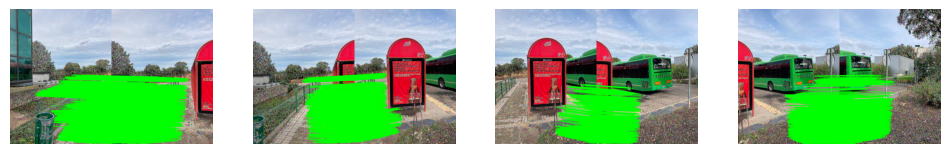

In [11]:
### TODO
# Draw correct matches

masks_inliers_sift = []

for idx, (elem1, elem2) in enumerate(pairs_sift):
    m = matches_sift[idx]

    pts1 = np.float32([keypoints_sift[elem1][match.queryIdx].pt for match in m]).reshape(-1, 1, 2)
    pts2 = np.float32([keypoints_sift[elem2][match.trainIdx].pt for match in m]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    masks_inliers_sift.append(mask.ravel().tolist())

_imgs = []
for idx, (elem1, elem2) in enumerate(pairs_sift):
    draw_params = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=masks_inliers_sift[idx], flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    _imgs.append(cv2.drawMatches(imgs[elem1], keypoints_sift[elem1], imgs[elem2], keypoints_sift[elem2], matches_sift[idx], None, matchesThickness=3, **draw_params))
draw_images(_imgs)

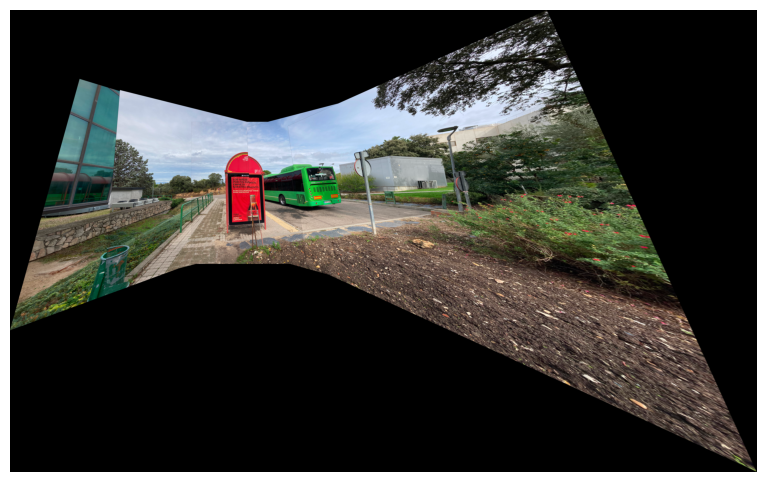

In [ ]:
import numpy as np
import cv2

mid_idx = len(imgs) // 2
homographies = [np.eye(3)] * len(imgs)

for i in range(mid_idx - 1, -1, -1):
    pts_i = np.float32([keypoints_sift[i][m.queryIdx].pt for m in matches_sift[i]]).reshape(-1, 1, 2)
    pts_next = np.float32([keypoints_sift[i+1][m.trainIdx].pt for m in matches_sift[i]]).reshape(-1, 1, 2)
    H_i_to_next, _ = cv2.findHomography(pts_i, pts_next, cv2.RANSAC, 5.0)
    homographies[i] = homographies[i+1] @ H_i_to_next

for i in range(mid_idx + 1, len(imgs)):
    pts_prev = np.float32([keypoints_sift[i-1][m.queryIdx].pt for m in matches_sift[i-1]]).reshape(-1, 1, 2)
    pts_i = np.float32([keypoints_sift[i][m.trainIdx].pt for m in matches_sift[i-1]]).reshape(-1, 1, 2)
    H_i_to_prev, _ = cv2.findHomography(pts_i, pts_prev, cv2.RANSAC, 5.0)
    homographies[i] = homographies[i-1] @ H_i_to_prev

def get_canvas_setup(imgs, homographies):
    all_coords = []
    for img, H in zip(imgs, homographies):
        h, w = img.shape[:2]
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        transformed = cv2.perspectiveTransform(pts, H)
        all_coords.append(transformed)
    
    all_coords = np.concatenate(all_coords, axis=0)
    [x_min, y_min] = all_coords.min(axis=0).ravel() - 0.5
    [x_max, y_max] = all_coords.max(axis=0).ravel() + 0.5
    
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    canvas_size = (int(x_max - x_min), int(y_max - y_min))
    return canvas_size, H_translation

canvas_size, H_trans = get_canvas_setup(imgs, homographies)

panorama = np.zeros((canvas_size[1], canvas_size[0], 3), dtype=np.uint8)

for i in range(len(imgs)):
    H_final = H_trans @ homographies[i]
    warped_img = cv2.warpPerspective(imgs[i], H_final, canvas_size)
    
    mask = (warped_img > 0)
    panorama[mask] = warped_img[mask]

draw_images([panorama])
